In [2]:
# %load /Users/hwayment/ipynb_defaults.py
%load_ext autoreload
%autoreload 2

%pylab inline
import numpy as np
import pandas as pd

import seaborn as sns
sns.set_style('ticks')
sns.set_context('paper')

from matplotlib.colors import LogNorm

from glob import glob
import os, sys, pickle, requests
from scipy.stats import linregress
import warnings

warnings.filterwarnings("ignore")

import EB_stats

tmp_pal=sns.color_palette('Set1',5)
standardized_palette = [tmp_pal[x] for x in [1,2,0,4,3]]+[[0,0,0],[128/255, 128/255,128/255],[128/255, 128/255,128/255]]

Populating the interactive namespace from numpy and matplotlib


In [3]:
df = pd.read_json('../Riboswitch/data/datasets_with_predictions/all_packages_est_bps_11May2020.json.zip')
# Contains all packages, evaluated on Ribologic FMN data, using base pair approximation.

df_subset = pd.read_json('../Riboswitch/data/datasets_with_predictions/subset_est_bps_11May2020.json.zip')
# Contains package subset, evaluated on all datasets, using base pair approximation.

pkg_list=['vienna_1','vienna_2','vienna_2_nodangles','vienna_2_60C',
          'vienna_langdon_pars','vienna_rnasoft_pars',
'nupack_99','nupack_99_nodangles','nupack_95','nupack_95_nodangles','rnastructure',
'rnastructure_nocoax','contrafold_1','contrafold_2','contrafold_2_nc',
'rnasoft_99','rnasoft_07',
'rnasoft_blstar','rnasoft_99_nodangles','rnasoft_bl_nodangles','rnasoft_lam-cg',
'rnasoft_nom-cg','eternafold_A','eternafold_B','eternafold_C','eternafold_D',
'eternafold_E','eternafold_F','eternafold_G','cyclefold','learntofold']

package_titles = ['Vienna 1', 'Vienna 2', 'Vienna 2, no dangles',
'Vienna 2, 60C', 'Vienna 2 `Langdon 2018` pars', 'Vienna 2 `RNASoft 2007` pars',
'NUPACK 1995', 'NUPACK 1995, no dangles', 'NUPACK 1999', 'NUPACK 1999, no dangles',
'RNAstructure', 'RNAstructure, no coaxial stacking',
'CONTRAfold 1', 'CONTRAfold 2', 'CONTRAfold 2, noncomplementary',  
'RNAsoft 1999', 'RNAsoft 1999, no dangles', 'RNAsoft 2007',
'RNAsoft BLstar', 'RNAsoft BL, no dangles', 'RNAsoft LAM-CG', 'RNAsoft NOM-CG',
'EternaFold_SRR', 'EternaFold_SCRR','EternaFold_S','EternaFold_SR','EternaFold_SC','EternaFold_C','EternaFold_R','CycleFold','LearnToFold']

packages = ['vienna_2', 'nupack_99', 'rnastructure','contrafold_2', 'rnasoft_blstar'] #,'eternafold_B']

df['dataset']='Ribologic, FMN'
df_subset['dataset'] = df_subset['Round'].astype(str)+', '+df_subset['ligand']

for pkg in packages:
    df_subset['log_pij_%s' % pkg] = -1*np.log(1e-13+df_subset['kfold_est_bp_%s' % pkg])
    
for pkg in pkg_list:
    df['log_pij_%s' % pkg] = -1*np.log(1e-13+df['kfold_est_bp_%s' % pkg])

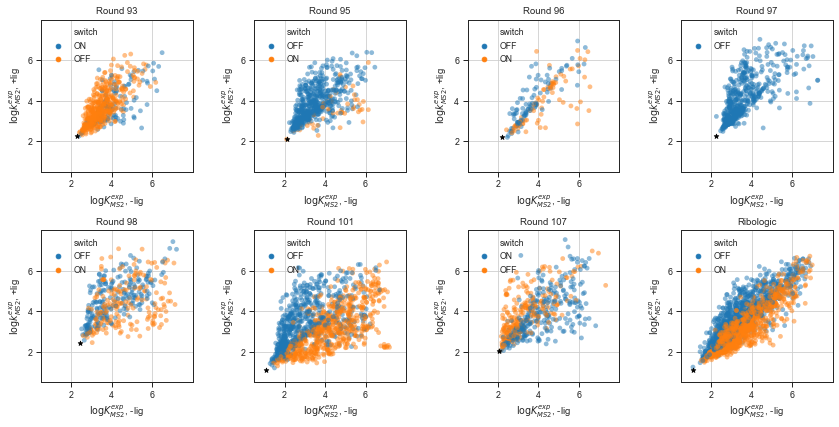

In [4]:
round_order = [93,95,96,97,98,101,107,'Ribologic']

figure(figsize=(12,6))
for i, rnd in enumerate(round_order):
    tmp_df = df_subset.loc[df_subset['Round']==rnd]
    subplot(2,4,i+1,aspect='equal')
    if rnd != 'Ribologic':
        title('Round %s' % rnd)
    else:
        title('Ribologic')
    sns.scatterplot(x='logkd_nolig',y='logkd_lig',hue='switch',data=tmp_df,linewidth=0,alpha=0.5)
    xlabel(r'$\log K_{MS2}^{exp}$, -lig')
    ylabel(r'$\log k_{MS2}^{exp}$, +lig')
    xlim([0.5,8])
    ylim([0.5,8])
    xticks([2,4,6])
    yticks([2,4,6])
    legend(frameon=False, loc='upper left')

    scatter(tmp_df['min_kd_val'].unique(),tmp_df['min_kd_val'].unique(),marker='*',color='k')
    grid()
    
tight_layout()

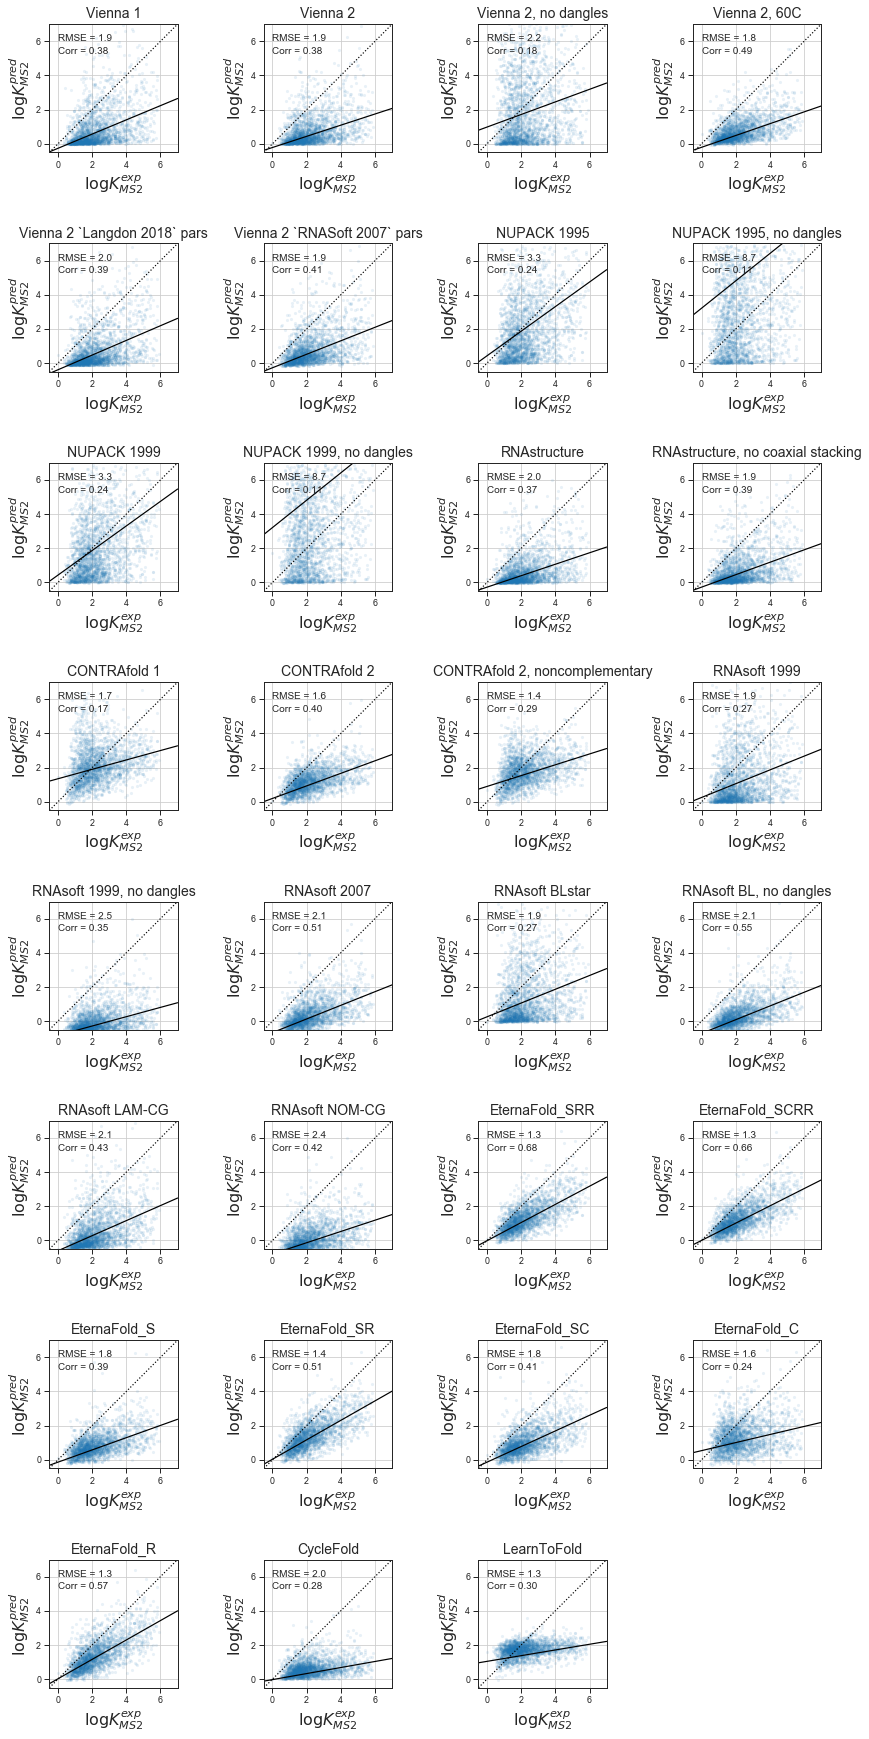

In [6]:
figure(figsize=(12,30))

xmin=-0.5
for i, pkg in enumerate(pkg_list):

    subplot(10,4,i+1,aspect='equal')
    sns.scatterplot(x='logkd_nolig_scaled',y='log_pij_%s' % pkg, data=df, alpha=0.1, linewidth=0, s=10)
    x=df['logkd_nolig_scaled']
    y=df['log_pij_%s' % pkg]
    rmse = np.sqrt(np.mean(np.square(x-y)))
    corr = np.corrcoef(x,y)[0][1]
    m, b = np.poly1d(np.polyfit(x, y, 1))
    #m, _, _, _ = np.linalg.lstsq(x.values.reshape(-1,1), y.values.reshape(-1,1))

    plot([xmin,7],[xmin+b,7*m+b],c='k')
    plot([xmin,7],[xmin,7],linestyle=':',c='k')

    xlabel(r'$\log K_{MS2}^{exp}$',fontsize=16)
    ylabel(r'$\log K_{MS2}^{pred}$',fontsize=16)
    title(package_titles[i],fontsize=14)
    text(0,6,"RMSE = %.1f" % rmse)
    text(0,5.25,"Corr = %.2f" % corr)
    
    xlim([xmin,7])
    ylim([xmin,7])
    xticks([0,2,4,6])
    yticks([0,2,4,6])
    grid()
    
tight_layout()

# Bootstrap pairwise comparisons

Increase `n_bootstraps` for improved accuracy, left at 100 for speed.

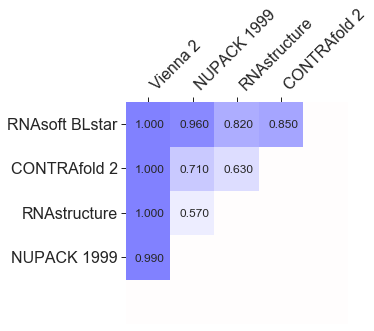

In [16]:
arr = EB_stats.bootstrap_all_datasets(df_subset, package_list =  packages,
                                           x_data='logkd_nolig_scaled', y_data='log_pij', n_bootstraps=100)

titles = [ 'NUPACK 1999', 'Vienna 2', 'RNAstructure', 'RNAsoft BLstar','CONTRAfold 2', ]

fig = EB_stats.plot_net_overview(arr, package_list=packages, titles=titles, reorder=[1,0,2,4,3], figsize=(5,5))

## Calculate pairwise comparison for all packages tested for Ribologic dataset

In [260]:
arr_ribologic = EB_stats.sig_over_individual_datasets(df, package_list = sorted_packages, x_data='logkd_nolig_scaled', y_data='log_pij',n_bootstraps=100)

<Figure size 1080x1080 with 0 Axes>

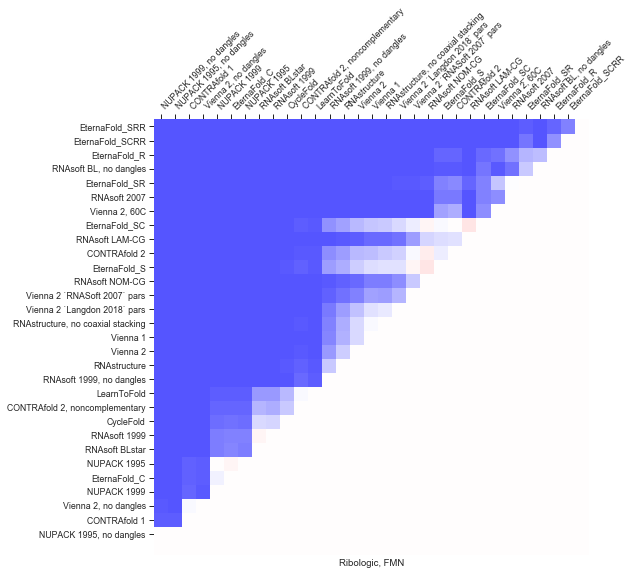

In [262]:
sorted_packages = ['nupack_95_nodangles','nupack_99_nodangles','contrafold_1','vienna_2_nodangles','nupack_95','eternafold_F','nupack_99','rnasoft_99_nodangles',
 'rnasoft_99','cyclefold','contrafold_2_nc','learntofold','rnasoft_07','rnastructure','vienna_2','vienna_1','rnastructure_nocoax','vienna_langdon_pars',
 'vienna_rnasoft_pars','rnasoft_nom-cg','eternafold_C','contrafold_2','rnasoft_lam-cg','eternafold_E','vienna_2_60C','rnasoft_blstar','eternafold_D',
 'rnasoft_bl_nodangles','eternafold_G','eternafold_B','eternafold_A']

figure(figsize=(15,15))
fig = EB_stats.plot_pairwise_matrices(arr_ribologic, n_rows=2,n_cols=2, titles=[package_titles[pkg_list.index(x)] for x in sorted_packages],
                                package_list = pkg_list, labels=False, figsize=(15,15))

fig.savefig('ribologic_all_options_pvals.pdf',bbox_inches='tight',transparent=True)

In [90]:
reorder_packages = ['nupack_99', 'vienna_2', 'rnastructure','rnasoft_blstar','contrafold_2']
test_dir = EB_stats.sig_over_individual_datasets(df_subset, x_data='logkd_nolig_scaled', y_data='log_pij', package_list= reorder_packages, n_bootstraps=1000)

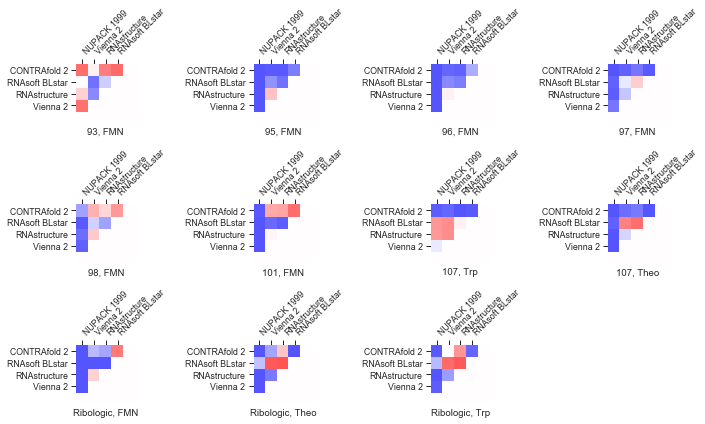

In [264]:
import textwrap
fig = EB_stats.plot_pairwise_matrices(test_dir, n_rows=3, n_cols=4, package_list = reorder_packages, titles = titles, labels=False, figsize=(10,6))

fig.savefig('pairwise_matrices_per_dataset_riboswitches.pdf',bbox_inches='tight',transparent=True)

# Bootstrap and plot individual correlations

In [36]:
correlation_data_subset = pd.DataFrame()

for dataset in df_subset['dataset'].unique():
    tmp_df = df_subset.loc[df_subset['dataset']==dataset]
    
    output, _, _ = EB_stats.bootstrap_metric(tmp_df, package_list=packages, n_bootstraps=100)
    output['dataset']=dataset
    correlation_data_subset = correlation_data_subset.append(output,ignore_index=True)
    

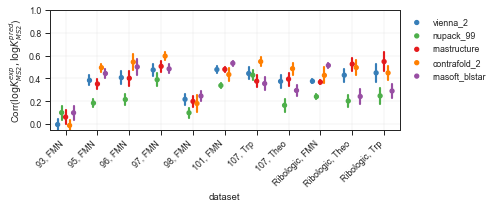

In [37]:
figure(figsize=(7,3))

ax = sns.pointplot(x='dataset', y='C', hue_order=packages, data=correlation_data_subset,
                 hue='package', join=False, ci='sd', marker='.', scale=0.75, dodge=0.5, palette=standardized_palette)
ylabel(r'Corr($\log K_{MS2}^{exp}, \log K_{MS2}^{pred}$)')
xticks(rotation=45,horizontalalignment='right')
ylim([-0.05,1])
grid(linewidth=0.2)
legend(bbox_to_anchor=(1,1), frameon=False)

tight_layout()

In [26]:
correlation_data = pd.DataFrame()

for dataset in df['dataset'].unique():
    tmp_df = df.loc[df['dataset']==dataset]
    
    output, _, _ = EB_stats.bootstrap_metric(tmp_df, package_list=pkg_list, n_bootstraps=100)
    correlation_data = correlation_data.append(output,ignore_index=True)
    

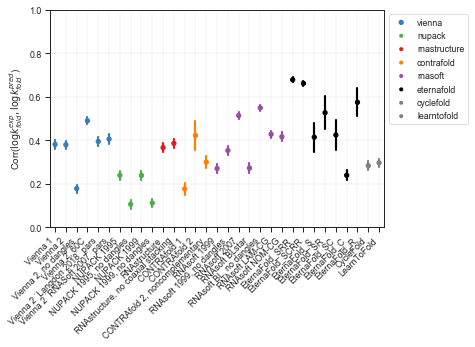

In [30]:
ax = sns.pointplot(x='package',y='C', order=pkg_list, data=correlation_data, hue='package_type', join=False,
        ci='sd', marker='.', scale=0.75, dodge=False,  palette=standardized_palette)
ylabel(r'Corr($\log k_{fold}^{exp}, \log k_{fold}^{pred}$)')
xticks(rotation=45,horizontalalignment='right')
ax.set_xticklabels(package_titles)
grid(linewidth=0.2)
xlabel('')
ylim([0,1])
legend(bbox_to_anchor=(1,1))

# Check if base pair and constrained partition function estimation are the same

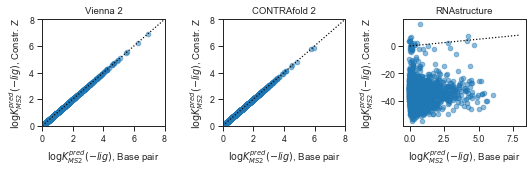

In [38]:
bp_df = pd.read_json('../Riboswitch/data/datasets_with_predictions/all_packages_est_bps_11May2020.json.zip')
Z_df = pd.read_json('../Riboswitch/data/datasets_with_predictions/all_packages_est_Z_11May2020.json.zip')

bp_df = bp_df.loc[bp_df['Round']=='Ribologic'][bp_df['ligand']=='FMN']
Z_df = Z_df.loc[Z_df['Round']=='Ribologic'][Z_df['ligand']=='FMN']

pkg_test_case=['vienna_2','contrafold_2','rnastructure']

for pkg in pkg_test_case:
    bp_df['log_pij_%s' % pkg] = -1*np.log(1e-13+bp_df['kfold_est_bp_%s' % pkg])
    
titles=['Vienna 2','CONTRAfold 2','RNAstructure',]
figure(figsize=(7.5,2.5))
for i,pkg in enumerate(pkg_test_case):
    subplot(1,3,i+1)
    scatter(bp_df['log_pij_%s' % pkg], Z_df['log_kfold_est_nolig_Z_%s' % pkg],alpha=0.5)
    xlabel(r'$\log K_{MS2}^{pred}(-lig)$, Base pair')
    ylabel(r'$\log K_{MS2}^{pred}(-lig)$, Constr. Z')
    plot([0,8],[0,8],color='k',linestyle=':')
    title(titles[i])
    if i!=2:
        xlim([0,8])
        ylim([0,8])
tight_layout()

# Example calculations from constrained partition function data

In [42]:
df_constr_Z = pd.read_json('../Riboswitch/data/datasets_with_predictions/subset_est_Z_11May2020.json.zip')
df_constr_Z['log_AR'] = np.log(df_subset['Activation Ratio'])
df_constr_Z['dataset'] = df_constr_Z['Round'].astype(str)+', '+df_constr_Z['ligand']

Z_package_subset = ['vienna_2', 'contrafold_2', 'eternafold_B']

In [45]:
Z_correlation_kdlig = pd.DataFrame()

for dataset in df_constr_Z['dataset'].unique():
    tmp_df = df_constr_Z.loc[df_constr_Z['dataset']==dataset]
    
    output, _, _ = EB_stats.bootstrap_metric(tmp_df, x_data='logkd_lig_scaled', y_data='log_kfold_est_lig_Z', package_list=Z_package_subset, n_bootstraps=100)
    output['dataset']=dataset
    Z_correlation_kdlig = Z_correlation_kdlig.append(output,ignore_index=True)
    

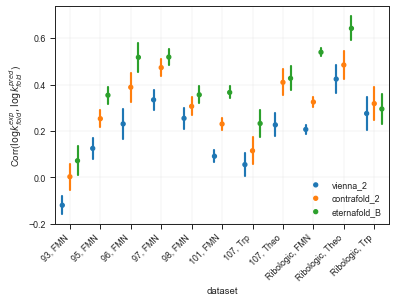

In [49]:
sns.pointplot(x='dataset', y='C', hue_order=['vienna_2', 'contrafold_2','eternafold_B'], data=Z_correlation_kdlig,
               hue='package',  join=False, ci='sd', marker='.', scale=0.75, dodge=0.5)
xticks(rotation=45,horizontalalignment='right')
grid(linewidth=0.2)
ylabel(r'Corr($\log k_{fold}^{exp}, \log k_{fold}^{pred}$)')
legend(frameon=False)

In [ ]:
overall_test_kdlig = EB_stats.bootstrap_all_datasets(df_constr_Z, package_list =  Z_package_subset, 
                                                x_data='logkd_lig_scaled', y_data='log_kfold_est_lig_Z',n_bootstraps=1000)

overall_test_AR = EB_stats.bootstrap_all_datasets(df_constr_Z, package_list =  Z_package_subset, 
                                                x_data='log_AR', y_data='log_AR_est',n_bootstraps=1000)